In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve,auc 

In [2]:
df = pd.read_csv("./Group_7_data_cleaned.csv")

In [3]:
df.drop(columns=['Date','Time'], inplace=True)

In [4]:
df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S5_CO2_Slope          10129 non-null  float64
 14  S6_PIR                10129 non-null  int64  
 15  S7_PIR             

## Estimating the Occupancy of the room after removing the light input variables as per problem statement

In [6]:
df_wo_light = df.drop(df.filter(regex='Light').columns, axis=1)

In [7]:
df_wo_light.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,0.08,0.19,0.06,0.06,390,0.77,0,0,1
1,24.94,24.75,24.56,25.44,0.93,0.05,0.06,0.06,390,0.65,0,0,1
2,25.00,24.75,24.50,25.44,0.43,0.11,0.08,0.06,390,0.52,0,0,1
3,25.00,24.75,24.56,25.44,0.41,0.10,0.10,0.09,390,0.39,0,0,1
4,25.00,24.75,24.56,25.44,0.18,0.06,0.06,0.06,390,0.25,0,0,1


In [8]:
X_wo_light = df_wo_light.drop(['Room_Occupancy_Count'], axis=1)
y_wo_light = df_wo_light[['Room_Occupancy_Count']]

In [9]:
# Splitting the dataset into train and test
X_train_wo_light, X_test_wo_light, y_train_wo_light, y_test_wo_light = train_test_split(X_wo_light, y_wo_light, test_size=0.2, random_state=42)

In [10]:
# Scaling the dataset
scaler = StandardScaler()
X_train_scaled_wo_light = scaler.fit_transform(X_train_wo_light)
X_test_scaled_wo_light = scaler.transform(X_test_wo_light)

In [11]:
model_classifier_wo_light = SGDClassifier(random_state=42)
model_classifier_wo_light.fit(X_train_scaled_wo_light, y_train_wo_light)

print("Accuracy on train set: ", model_classifier_wo_light.score(X_train_scaled_wo_light, y_train_wo_light))
print("Accuracy on test set: ", model_classifier_wo_light.score(X_test_scaled_wo_light, y_test_wo_light))

Accuracy on train set:  0.9445884240404788
Accuracy on test set:  0.9338598223099703


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Hyperparameter Tuning using GridSearch

In [12]:
%%time

#Defining hyperparameters
loss = ["hinge", "log", "squared_hinge", "modified_huber"]
penalty = ['l1','l2','none']
alpha = [0.0001, 0.001, 0.01, 0.1]
    
# define grid search
grid = dict(loss=loss, penalty=penalty, alpha=alpha)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search = GridSearchCV(estimator=model_classifier_wo_light, param_grid=grid, n_jobs=-1, 
                           cv=cv, scoring='accuracy', error_score=0)

#Results
grid_result = grid_search.fit(X_train_scaled_wo_light, y_train_wo_light)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.948990 using {'alpha': 0.001, 'loss': 'log', 'penalty': 'none'}
0.942490 (0.007674) with: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'}
0.945081 (0.007440) with: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
0.944301 (0.006338) with: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'none'}
0.942202 (0.004544) with: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}
0.945040 (0.004981) with: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}
0.943313 (0.004566) with: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'none'}
0.904977 (0.029309) with: {'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'l1'}
0.901356 (0.047182) with: {'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.850601 (0.170699) with: {'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'none'}
0.937265 (0.009203) with: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l1'}
0.934386 (0.008526) with: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'}
0.936156 (0.009018) with: {'

C:\Users\aryan\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Linear Classifier Model with best hyperparameters

In [13]:
model_classifier_wo_light = SGDClassifier(alpha=0.001, loss= 'log', penalty= 'none', random_state=42)
model_classifier_wo_light.fit(X_train_scaled_wo_light, y_train_wo_light)

print("Accuracy on test set: ", model_classifier_wo_light.score(X_test_scaled_wo_light, y_test_wo_light))

Accuracy on test set:  0.9397828232971372


C:\Users\aryan\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


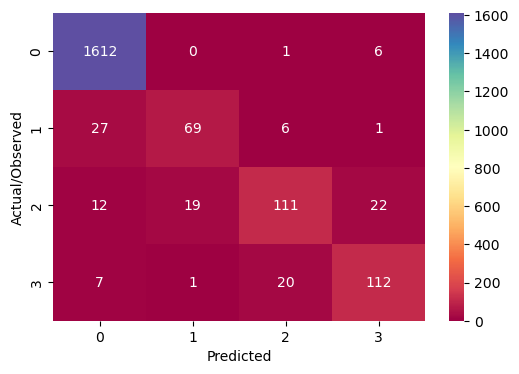

In [14]:
y_predicted = model_classifier_wo_light.predict(X_test_scaled_wo_light)
cm = confusion_matrix(y_test_wo_light, y_predicted)
plt.figure(figsize = (6,4))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral",
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10);

In [15]:
print(classification_report(y_test_wo_light, y_predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1619
           1       0.78      0.67      0.72       103
           2       0.80      0.68      0.74       164
           3       0.79      0.80      0.80       140

    accuracy                           0.94      2026
   macro avg       0.84      0.79      0.81      2026
weighted avg       0.94      0.94      0.94      2026



In [17]:
# Saving the model with pickle
import pickle
filename = 'linear_classification_model.sav'
pickle.dump(model_classifier_wo_light, open(filename, 'wb'))